# MMIA - Master Degree Thesis

## Predictions for long duration trail running activities

## Data Processing

The data processing logic is implemented in the `DataProcessor` class within the file [data_processor.py](utils/data_processor.py). The recording device is a Polar Vantage V watch. Polar data is structured in JSON format, so it's essential to convert it into a tabular format before feeding it into the model.

This processing involves extracting and transforming information from JSON files containing trail running activity records. The script filters activities by sport type (`TRAIL_RUNNING`) and duration (between 4 and 6 hours). For each valid activity, sensor samples, such as heart rate, altitude, distance, temperature, cadence, and speed, are extracted.

These samples are organized into a DataFrame, where several feature engineering tasks are performed:

- **Distance**: The difference between consecutive samples is computed to obtain interval-by-interval progress.  
- **Altitude**: The data is smoothed, and elevation differences, cumulative ascent, and cumulative descent are calculated.  
- **Duration**: Cumulative time between samples is computed.

Processing is performed efficiently, supporting multithreading to accelerate file conversion. The resulting processed data is saved into structured CSV files, ready for analysis and modeling.

### Data Resampling

The goal of the project is to predict race time, so the data was resampled to ensure samples are spaced at constant distance intervals. The resampling logic is implemented in the `DataResampler` class in the file [data_resampling.py](./utils/data_resampling.py).

The activity data files from the previous step were transformed so that samples are evenly spaced at fixed distance intervals (every 5 meters). This process included:

- Loading the data and converting the timestamp column to datetime format.  
- Filling missing values in heart rate, cadence, speed, and distance using either the mean or the previous value.  
- Removing duplicates and creating a new distance-based index with 2-meter steps.  
- Interpolating values to obtain continuous data at these regular intervals.  
- Saving the resampled data as CSV files in an output folder.

### Exploratory Data Analysis

In [1]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Define the directory containing the processed data
data_dir = "./data/resampled"
# Get the training files list
training_files=os.listdir(data_dir)

# Get the files count
print(f"Number of training files: {len(training_files)}")

Number of training files: 101


In [2]:
# Load and process all CSV files
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453667 entries, 0 to 453666
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   distance                     453667 non-null  float64
 1   timestamp                    453667 non-null  object 
 2   heartRate                    453667 non-null  float64
 3   altitude                     453667 non-null  float64
 4   altitude_raw                 453667 non-null  float64
 5   temperature                  453667 non-null  float64
 6   cadence                      453667 non-null  float64
 7   speed                        453667 non-null  float64
 8   duration                     453667 non-null  float64
 9   elevation_diff               453667 non-null  float64
 10  elevation_gain               453667 non-null  float64
 11  elevation_loss               453667 non-null  float64
 12  duration_diff                453667 non-null  float64
 13 

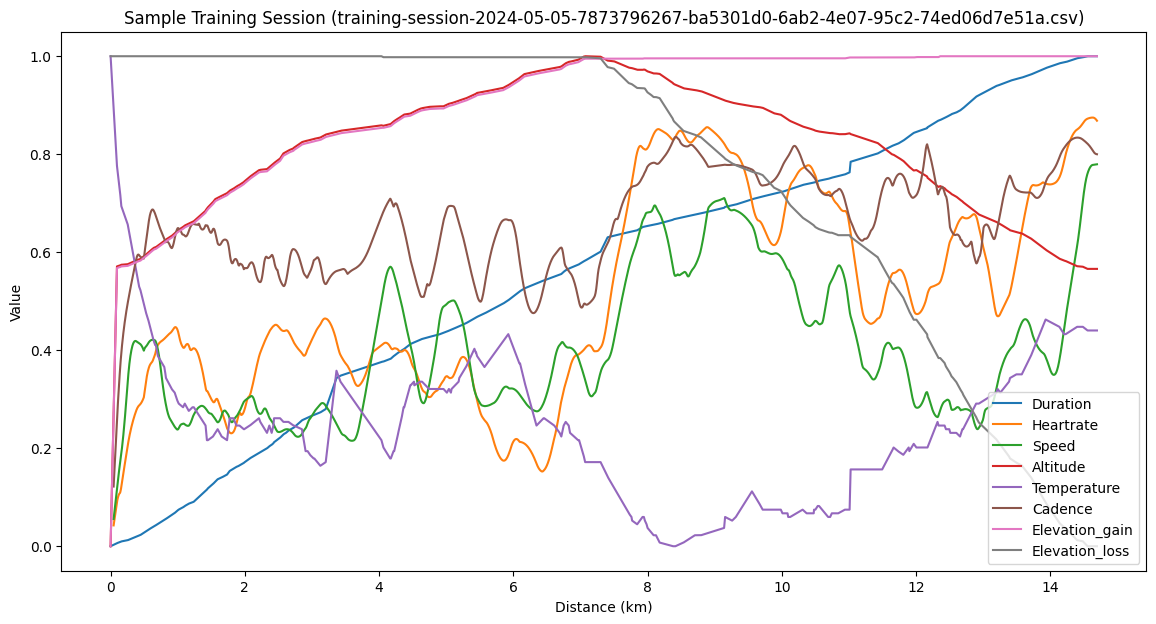

In [3]:
# Plot heart rate over distance
random.seed(4242)
sample_file = random.choice(training_files)
sample_path = os.path.join(data_dir, sample_file)
sample_data = pd.read_csv(sample_path)

#Normalize sample data (scale between 0 and 1 for better visualization)
normalized_cols = {}
for col in ['duration', 'heartRate', 'speed', 'altitude', 'temperature', 'cadence', 'elevation_gain', 'elevation_loss']:
    normalized_cols[col] = (sample_data[col] - sample_data[col].min()) / (sample_data[col].max() - sample_data[col].min())

# Smooth speed data using rolling average for visualization
normalized_cols['speed'] = normalized_cols['speed'].rolling(window=100, min_periods=10).mean()
normalized_cols['heartRate'] = normalized_cols['heartRate'].rolling(window=100, min_periods=10).mean()
normalized_cols['cadence'] = normalized_cols['cadence'].rolling(window=100, min_periods=10).mean()

plt.figure(figsize=(14, 7))
distance_km = sample_data['distance'] / 1000
for col in normalized_cols:
    plt.plot(distance_km, normalized_cols[col], label=col.capitalize())

plt.xlabel('Distance (km)')
plt.ylabel('Value')
plt.title(f'Sample Training Session ({sample_file})')
plt.legend()
plt.show()


At a glance, certain correlations between some of the variables can be observed. We expect the TFT model will then select the most appropriate variables for the case.

### DataModule

The `TFTDataModule` class was implemented using PyTorch Lightning’s `LightningDataModule` and the `TimeSeriesDataSet` class from the `pytorch-forecasting` library, which is specifically designed for time series modeling.

#### Data Loading

The module loads data automatically. The `prepare_data` function reads all available data and performs necessary preprocessing steps to integrate it with `pytorch-forecasting` components. For example, session identifiers are added as a categorical variable, and distance values are converted into a sequential `time_idx`, which is required by `TimeSeriesDataSet`.

#### Data Splitting

Initially, the data was split temporally into 70:15:15 proportions for training, validation, and test sets, respectively—following standard best practices for time series to prevent data leakage from future to past during validation and testing. However, since the project’s goal is to enable the model to handle *cold-start* scenarios (i.e., predicting before the athlete has even begun the route), the split was instead performed by session rather than by time, using a 75:15:10 ratio to provide slightly more context for training.

The DataModule implementation also includes:

- **Group-wise normalization**: Applies a `GroupNormalizer` per session to improve generalization.  
- **Future covariates handling**: Distinguishes between known and unknown future variables.

**Key configurable parameters:**
- `max_encoder_length`: Maximum encoder length (20 steps)  
- `max_prediction_length`: Prediction horizon (200 steps)  
- `batch_size`: Training batch size (64)  
- `target`: Target variable(s) to predict (`duration_diff`, `heart_rate`, `temperature`, `cadence`)

**Known future-dependent variables** (available at prediction time):  
- `altitude`: Altitude  
- `elevation_diff`: Elevation difference  
- `elevation_gain`: Cumulative elevation gain  
- `elevation_loss`: Cumulative elevation loss  
- `distance`: Distance covered  

**Unknown future-dependent variables:**  
- `duration_diff`: Interval duration  
- `heartRate`: Heart rate  
- `temperature`: Temperature  
- `cadence`: Cadence  
- `speed`: Speed  

The underlying hypothesis is that, when provided with appropriate contextual information about the terrain and route, the Temporal Fusion Transformer (TFT) model will be able to generate highly accurate predictions of race completion time.

In [4]:
# Import the TFT DataModule
# import sys
# sys.path.append('./utils')
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=2,
    max_encoder_length=200,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()


Loading 106 training session files...
Loaded 106 sessions with 465939 total data points
Minimum required sequence length: 400
Valid sessions: 106/106
Session-based splits for cold-start evaluation:
Train sessions: 79, Val sessions: 15, Test sessions: 12
Train data points: 347748, Val: 72019, Test: 46172
Overlap between train-val: 0, train-test: 0
Training samples: 347511
Validation samples: 71974
Test samples: 12


In [5]:
# Get a sample batch to understand the data structure
train_loader = data_module.train_dataloader()
sample_batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"Batch type: {type(sample_batch)}")
print(f"Input features shape: {sample_batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target length: {len(sample_batch[1][0])}")          # Number of target variables
print(f"Target variable shape: {sample_batch[1][0][2].shape}")    # [batch_size, prediction_length]


Batch structure:
Batch type: <class 'tuple'>
Input features shape: torch.Size([64, 200, 21])
Target length: 5
Target variable shape: torch.Size([64, 200])


## Modelo

### Temporal Fusion Transformer (TFT)

The **Temporal Fusion Transformer** (TFT) is a deep learning model specifically designed for time series forecasting that can handle both known and unknown future variables.

Initially, a custom architecture was implemented within the `TrailRunningTFT` class, focused on predicting race time for trail running activities, structured as a *PyTorch Lightning* module. This involved instantiating the `TemporalFusionTransformer` model from the `pytorch-forecasting` library inside the custom class. However, since the `TemporalFusionTransformer` class is already implemented as a native *PyTorch Lightning* module, this extra wrapping proved unnecessary. Instead, the approach was revised to directly extend the existing `TemporalFusionTransformer` class, allowing domain-specific customizations tailored to trail running activities.

**Model characteristics:**
- **Architecture**: Based on the Temporal Fusion Transformer, optimized for sequential (time series) data  
- **Known future variables**: `altitude`, `elevation_diff`, `elevation_gain`, `elevation_loss`, `distance_diff` (available at prediction time)  
- **Unknown future variables**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`  
- **Target variables**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`  
- **Input sequence length**: 1–20 time steps  
- **Prediction horizon**: 200 steps into the future

## Training

Training was implemented in a separate script located in the file [training.py](./training.py) to enable standalone execution and optimal resource utilization. Metrics were logged at each epoch to allow monitoring of the training process.

The code below can be used to run training directly within the notebook.

In [6]:
# # Entrenar el modelo
# import subprocess
# import sys

# # Ejecuta el script de entrenamiento usando subprocess
# script_path = "training.py"

# # Verificar que el script existe
# if not os.path.exists(script_path):
#     print(f"Error: No se encontró el archivo {script_path}")
#     exit(1)

# print("Iniciando entrenamiento del modelo TFT...")

# try:
#     # Ejecutar el script con subprocess
#     process = subprocess.Popen(
#         [sys.executable, script_path],
#         stdout=subprocess.PIPE,
#         stderr=subprocess.STDOUT,
#         universal_newlines=True,
#         bufsize=1
#     )
    
#     # Mostrar la salida en tiempo real
#     for line in process.stdout:
#         print(line.rstrip())
    
#     # Esperar a que termine el proceso
#     process.wait()
    
#     if process.returncode == 0:
#         print("Entrenamiento completado exitosamente!")
#     else:
#         print("\n" + "=" * 60)
#         print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
# except Exception as e:
#     print(f"Error al ejecutar el script: {str(e)}")


📊 Hyperparameters for version_2:
learning_rate            : 0.001
dropout                  : 0.2
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 150
max_prediction_length    : 20
min_encoder_length       : 30
weight_decay             : 0.0
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 170 (150 encoder + 20 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_2...


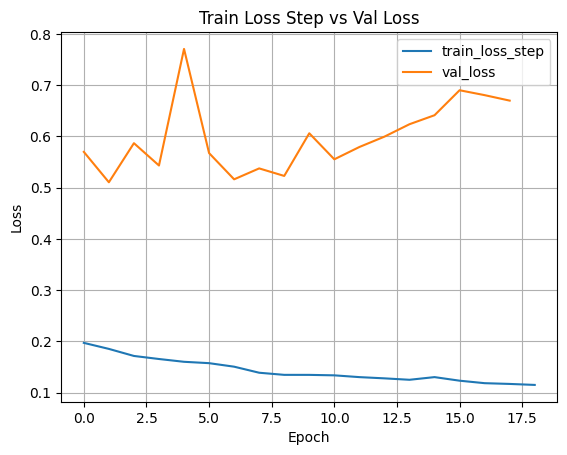


📊 Hyperparameters for version_8:
learning_rate            : 0.001
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 20
min_encoder_length       : 40
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 220 (200 encoder + 20 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_8...


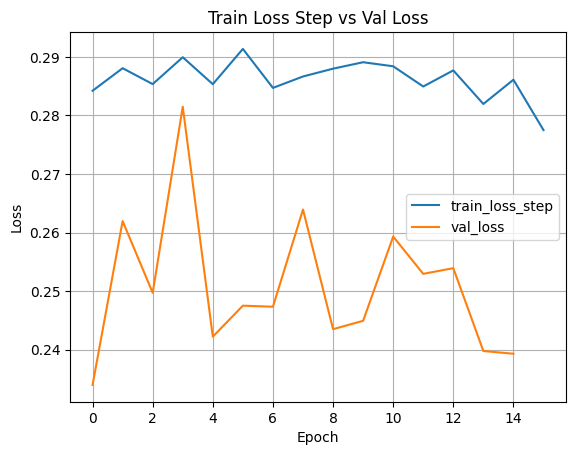


📊 Hyperparameters for version_11:
learning_rate            : 0.001
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 2
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_11...


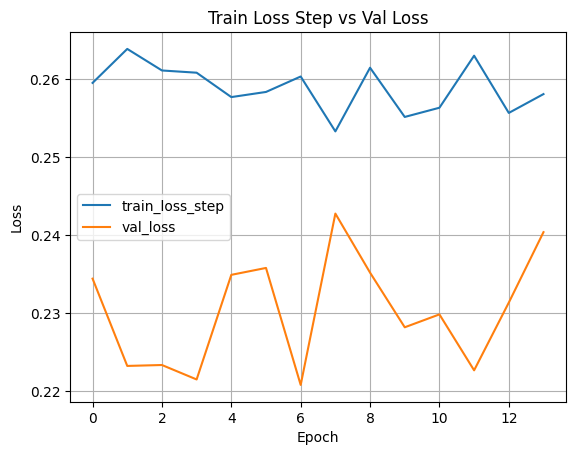


📊 Hyperparameters for version_13:
learning_rate            : 0.0005
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 2
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_13...


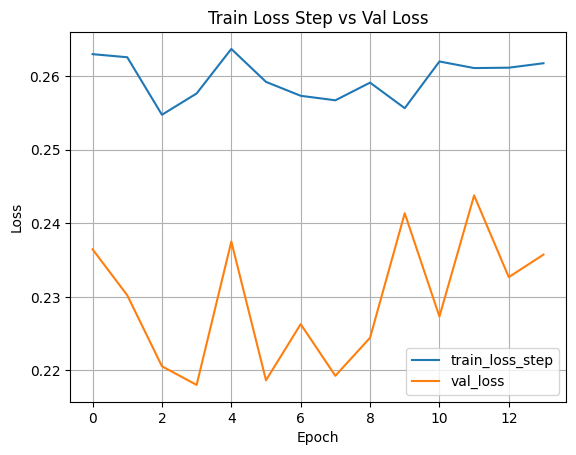

In [ ]:
import os
import importlib
# reload utils.viz to ensure latest changes are used
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_metrics, extract_hparams

# Plot training and validation loss and extract hyperparameters
logs_dir = "./logs/tft_model/"
for version in ['version_0']:
    version_path = os.path.join(logs_dir, version)
    if not os.path.isdir(version_path):
        continue
    metrics_file = os.path.join(version_path, "metrics.csv")
    hparams_file = os.path.join(version_path, "hparams.yaml")
    
    # Extract and display hyperparameters (if they exist)
    if os.path.exists(hparams_file):
        print(f"\n📊 Hyperparameters for {version}:")
        print("=" * 50)
        
        try:
            params = extract_hparams(hparams_file)
            
            # Define the parameters we're interested in
            key_params = [
                'learning_rate',
                'dropout',
                'hidden_size',
                'hidden_continuous_size',
                'attention_head_size',
                'lstm_layers',
                'max_encoder_length',
                'max_prediction_length',
                'min_encoder_length',
                'weight_decay',
                'causal_attention',
                'optimizer',
                'reduce_on_plateau_patience',
                'reduce_on_plateau_min_lr',
                'reduce_on_plateau_reduction',
                'randomize_length',
                'predict_mode',
            ]
            
            # Display found parameters
            for param in key_params:
                if param in params:
                    print(f"{param:25}: {params[param]}")
            
            # Calculate and display total sequence length
            encoder_len = params.get('max_encoder_length', 'N/A')
            pred_len = params.get('max_prediction_length', 'N/A')
            if isinstance(encoder_len, int) and isinstance(pred_len, int):
                total_len = encoder_len + pred_len
                print(f"{'Total Sequence Length':25}: {total_len} ({encoder_len} encoder + {pred_len} prediction)")
            
            # Display target variables
            if 'target_variables' in params:
                print(f"{'target_variables':25}: {', '.join(params['target_variables'])}")
            
        except Exception as e:
            print(f"Error processing {hparams_file}: {str(e)}")
        
        print("\n" + "=" * 50 + "\n")

    if os.path.exists(metrics_file):
        print(f"Plotting metrics for {version}...")
        plot_metrics(
            metrics_file,
            plot_metrics=[["train_loss_step", "val_loss"]],
            # save_svg_path=os.path.join("./assets/", f"loss_plot_{version}.svg")
        )

## Overfitting Analysis

One of the main objectives was to reduce overfitting while preserving the model’s predictive capability. Analysis of metrics from initial training runs revealed clear signs of overfitting. Several potential causes were identified:

### Dataset Size and Diversity vs. Model Complexity

The primary issue was the limited number of samples, driven by two factors: (1) filtering for relatively long training sessions capable of capturing endurance-related physiological patterns, and (2) intentionally restricting dataset size to accelerate training. At the same time, the model was configured to process long sequence lengths to capture dependencies over larger time windows. However, this increased the number of trainable parameters, making the model overly complex relative to the available data.

Another issue is that many sessions were conducted under varying conditions unknown to the model, including:
- No distinction between training and competition sessions. The Rate of Perceived Exertion (RPE) differs significantly: long training sessions typically maintain an RPE of 3–4, with brief intervals at RPE 5–8, whereas competitions predominantly operate at RPE 5–8, with recovery periods at RPE 2–4.  
- Lack of information on caloric intake, hydration, or ergogenic aids, all of which can significantly impact athletic performance.

A future improvement will involve expanding the dataset with more samples and enriching it with additional metadata such as RPE labels.

### Data Imbalance

An initial configuration used `predict=True` in `TimeSeriesDataSet.from_dataset()` for the validation set, which generated only **one sample per session** for validation. While this initially seemed reasonable, given that the data split was session-based, it created a significant imbalance when compared to the much larger number of training samples produced by the training dataloader. After reviewing the library documentation (https://pytorch-forecasting.readthedocs.io/en/v1.4.0/api/pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.from_dataset), it became clear that this parameter controls whether only the final sequence per series is used (`predict=True`) or multiple subsequences are generated (`predict=False`). The setting was changed to `predict=False` to obtain multiple validation samples per session, ensuring a more balanced evaluation.

### Excessively Long Sequences

The model was initially configured with an encoder length of 250 steps plus a prediction horizon of 50 steps (300 total steps), aiming to capture long-range temporal dependencies relevant to endurance activities. However, this made the model too complex for the dataset size. Various encoder/prediction length combinations were tested without significant improvement. Ultimately, the configuration was reduced to an encoder length of 200 steps and a prediction horizon of 40 steps (240 total steps).

### Insufficient Regularization

Initially, sequence lengths were not randomized, dropout was low (0.1), and `weight_decay` was not enabled for regularization. To address this, `randomize_length=True` was activated, dropout was increased to 0.3, and `weight_decay` was added to the optimizer.

### Complex Multi-Target Prediction

The model simultaneously predicts 5 target variables using 21 input features. To handle the varying scales and importance of these targets, a weighted loss function was implemented as a solution.

## Evaluación

In [16]:
import torch
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from training import find_latest_checkpoint
from lib.model import TrailRunningTFT

# Evaluate the model
logger = CSVLogger(
    save_dir="./logs/tft_model/",
    name="tft_evaluation",
    version=0
)

# Load the trainer on the latest checkpoint
trainer = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    strategy='auto',
    logger=logger,
    devices='auto',
    enable_checkpointing=True,
    precision="32-true",
    callbacks=[]
)

model = TrailRunningTFT.from_dataset(
    data_module.training,
    hidden_size=64,
    learning_rate=0.001,
    output_size=[1] * 5, # Multi-target output 
)

ckpt_path = find_latest_checkpoint()
if (not ckpt_path):
    print("No checkpoint found, cannot evaluate model.")
    exit(1)

print(f"Cargando modelo desde checkpoint: {ckpt_path}")

# Test the model on test dataset
test_results = trainer.test(model, data_module.test_dataloader(), ckpt_path=ckpt_path)


INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

Initialized MultiLoss with target weights:
  duration: 80.0%
  heartRate: 5.0%
  temperature: 5.0%
  cadence: 5.0%
  speed: 5.0%


INFO: Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt


Cargando modelo desde checkpoint: ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=10-val_loss=0.22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     cadence test_MAE      │     9.978601455688477     │
│     cadence test_RMSE     │    10.566987991333008     │
│    cadence test_SMAPE     │    0.13000725209712982    │
│     duration test_MAE     │     2446.121337890625     │
│    duration test_RMSE     │     2860.80810546875      │
│    duration test_SMAPE    │    0.1721944361925125     │
│    heartRate test_MAE     │    17.896711349487305     │
│    heartRate test_RMSE    │     20.18764305114746     │
│   heartRate test_SMAPE    │    0.13056083023548126    │
│      speed test_MAE       │    3.3274331092834473     │
│      speed test_RMSE      │    3.7737717628479004     │
│     speed test_SMAPE      │    0.35667693614959717    │
│   temperature test_MAE    │     5.36759614944458      │
│   temperature test_RMSE   │     6.181943893432617     │
│  temperature test_SMAPE   │    0.3178606331348419     │
│         test_loss         │    0.18451082706451416    │
└───────────────────────────┴───────────────────────────┘

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

=== Visualizing Duration (Target 0) for Batch 0 ===


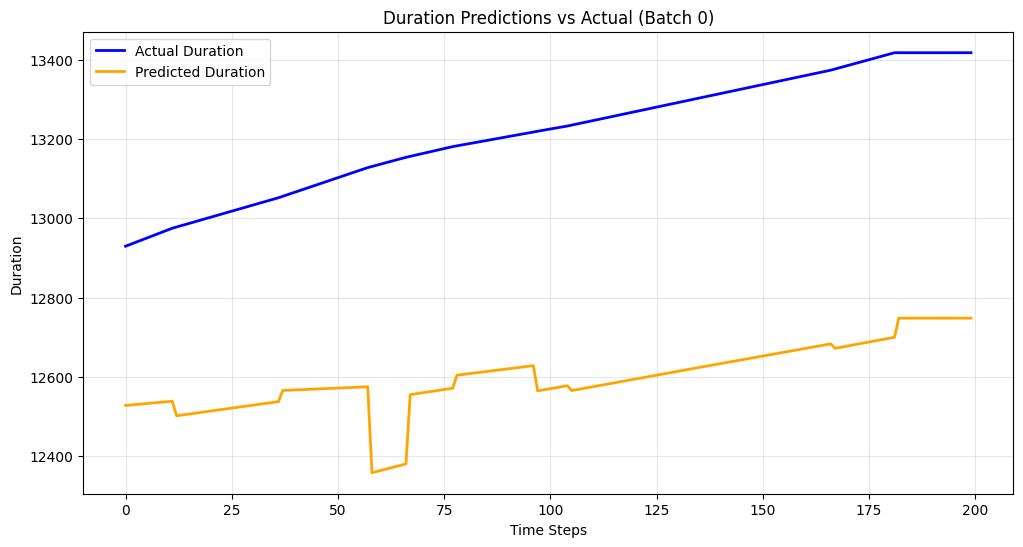


Error Metrics for Duration (Batch 0):
MSE: 388383.0312
MAE: 616.2242
RMSE: 623.2039

=== Visualizing Heart Rate (Target 1) for Batch 0 ===


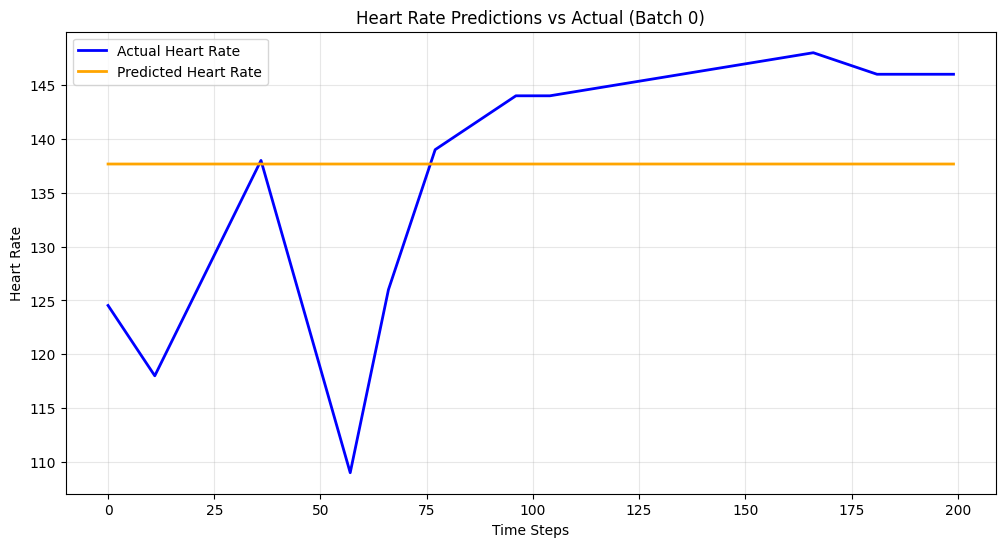


Error Metrics for Heart Rate (Batch 0):
MSE: 119.5399
MAE: 9.5058
RMSE: 10.9334

=== Visualizing Duration (Target 0) for Batch 1 ===


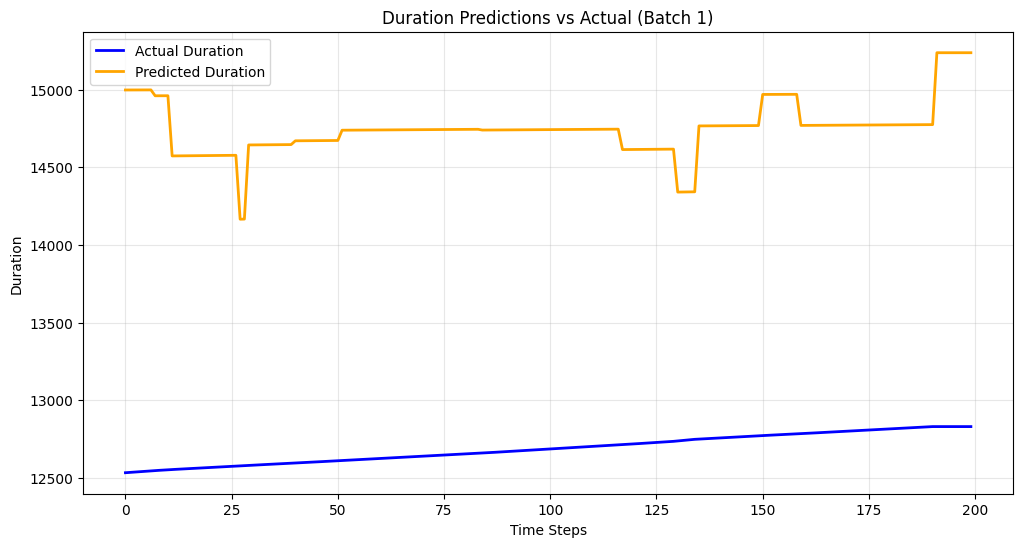


Error Metrics for Duration (Batch 1):
MSE: 4266148.5000
MAE: 2059.1680
RMSE: 2065.4656


In [33]:
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import visualize_predictions

raw_predictions = model.predict(
    data_module.test_dataloader(), mode="raw", return_x=True
)

# Example usage - visualize different batches and targets
target_names = ["Duration", "Heart Rate", "Temperature", "Cadence", "Speed"]

# Visualize duration for batch 0
print("=== Visualizing Duration (Target 0) for Batch 0 ===")
pred_duration, act_duration = visualize_predictions(raw_predictions, batch_id=0, target_idx=0, target_name="Duration")

# Visualize heart rate for batch 0
print("\n=== Visualizing Heart Rate (Target 1) for Batch 0 ===")
pred_hr, act_hr = visualize_predictions(raw_predictions, batch_id=0, target_idx=1, target_name="Heart Rate")

# If you have multiple batches, visualize a different batch
print("\n=== Visualizing Duration (Target 0) for Batch 1 ===")
try:
    pred_duration_b1, act_duration_b1 = visualize_predictions(raw_predictions, batch_id=1, target_idx=0, target_name="Duration")
except IndexError:
    print("Batch 1 not available (only 1 batch in dataset)")

## Conclusiones

Este proyecto desarrolló exitosamente un modelo de predicción para actividades de trail running utilizando un **Temporal Fusion Transformer (TFT)**, demostrando la viabilidad de aplicar técnicas avanzadas de deep learning para predicción de series temporales en el dominio deportivo.

### Logros Principales

Se implementó un pipeline robusto con un sistema completo de procesamiento de datos desde archivos JSON de Polar hasta datasets estructurados. El remuestreo a intervalos constantes de distancia (cada 5 metros) permitió crear secuencias temporales coherentes. La división basada en sesiones (75:15:10) favoreció el aprendizaje del modelo y permitió realizar validaciones y evaluaciones relevantes.

A pesar de los retos que representa la predicción multivariable en series temporales, el modelo TFT demostró capacidad para predecir simultáneamente 5 variables objetivo: duración, frecuencia cardíaca, temperatura, cadencia y velocidad. La distinción entre variables conocidas futuras (terreno/elevación) y desconocidas (métricas fisiológicas) reflejó la realidad de la predicción deportiva. Se logró capturar dependencias temporales complejas en ventanas de 200 pasos de entrada y 200 pasos de predicción

Se diagnosticaron y abordaron múltiples fuentes de sobreajuste: complejidad del modelo vs. tamaño del dataset, desbalance en datos de validación, secuencias excesivamente largas y falta de regularización. Algunas de las técnicas implementadas (`randomize_length`, dropout aumentado a 0.3, `weight_decay`) mejoraron la generalización del modelo pero todavía hay trabajo que se necesita realizar para mejorar el desempeño del modelo

### Desafíos y Limitaciones

El conjunto limitado de sesiones (106 sesiones en total) restringió la diversidad del modelo. La falta de distinción entre entrenamientos y competencias impactó la capacidad predictiva

Factores críticos como RPE (Rate of Perceived Effort), hidratación, nutrición y ayudas ergogénicas no fueron incluidos al no tener esa información relevante disponible. Condiciones ambientales específicas y estado de fatiga previo no se capturaron

Las secuencias largas incrementaron significativamente los requerimientos computacionales. El balance entre capacidad predictiva y eficiencia computacional requirió múltiples iteraciones

### Contribuciones al Campo

1. **Aplicación Novel**: Primera implementación documentada de TFT para predicción deportiva en trail running
2. **Metodología Replicable**: Pipeline completo desde datos brutos hasta modelo entrenado, aplicable a otros deportes de resistencia
3. **Insights de Overfitting**: Análisis detallado de técnicas de regularización específicas para series temporales deportivas

### Proximos pasos

1. **Expansión del Dataset**: Incluir mayor diversidad de sesiones, condiciones climáticas, tipos de terreno.
2. **Variables Contextuales**: Incorporar RPE, métricas de recuperación y factores nutricionales
3. **Optimización de Arquitectura**: Implementar un esquema de optimización de hiperparámetros a través de validación cruzada. Explorar arquitecturas híbridas y técnicas de transfer learning
4. **Aplicaciones Prácticas**: Desarrollo de interfaces para atletas y entrenadores

### Reflexión Final

Este proyecto demostró que los modelos de deep learning pueden capturar la complejidad inherente en las actividades deportivas de resistencia. Aunque existen limitaciones en el dataset actual, la metodología establecida y las lecciones aprendidas sobre overfitting proporcionan una base sólida para futuras investigaciones en la intersección entre inteligencia artificial y ciencias del deporte.

El éxito en la predicción multi-objetivo y la capacidad del modelo para manejar variables conocidas y desconocidas abre posibilidades para aplicaciones prácticas en planificación de entrenamientos, estrategia de carrera y optimización del rendimiento deportivo.